In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import matplotlib.cm as cm
from scipy.misc import imresize
import cv2
import pandas as pd
import scipy.io as io

In [2]:
def data_extraction(path):
    data_l, data_r, data_all = [], [], []
    nor_data = io.loadmat(path)
    temp = nor_data['data']
    r = temp['right']
    l = temp['left']
    r_temp = r[0,0]
    l_temp = l[0,0]
    data_r.append(r_temp['image'][0][0])
    data_r.append(r_temp['gaze'][0][0])
    data_r.append(r_temp['pose'][0][0])
    data_l.append(l_temp['image'][0][0])
    data_l.append(l_temp['gaze'][0][0])
    data_l.append(l_temp['pose'][0][0])
    for i in range(3):
        data_all.append(data_r[i])   #0 -> r_img, 1-> l_img, 2-> r_gaze, 3->l_gaze..
        data_all.append(data_l[i])
    return data_all

In [3]:
def label_extraction(path, screen_path):
    txt = pd.read_csv(path, sep = ' ', header= None)
    screen = io.loadmat(screen_path)
    df_anno = pd.DataFrame(txt)
    data_frame = pd.DataFrame()
    data_frame['Screen_x'] = df_anno[:][24] / screen['width_pixel'][0][0]
    data_frame['Screen_y'] = df_anno[:][25] / screen['height_pixel'][0][0]
    return data_frame

In [4]:
def path_optimization(day_list, path):
    all_path = []
    cnt = 0
    for i in range(len(day_list)): # 15번 
        temp = []
        for j in range(day_list[i]):
            temp.append(path[cnt])
            cnt += 1
        all_path.append(temp)
    return all_path

day_list = [39, 69, 39, 65, 25, 38, 62, 56, 47, 20, 16, 19, 7, 12, 7]  
data_path = glob('../Data/MPIIGaze/Data/Normalized/*/*')# 521개
data_path.sort()    #Sort for prevent index error
data_path = path_optimization(day_list, data_path)
#data_path = path_optimization(glob('C:/MPIIGaze/MPIIGaze/Data/Normalized/*/*'))
label_path = glob('../Data/MPIIGaze/Data//Original/*/*/annotation.txt') # 521개
label_path.sort()
label_path = path_optimization(day_list, label_path)
#label_path = path_optimzation(glob('C:/MPIIGaze/MPIIGaze/Data/Original/*/*/annotation.txt'))
screen_size_path = glob('../Data/MPIIGaze/Data/Original/*/Calibration/screenSize.mat') # 15개

for i in range(15): # 총 15명
    data = [] # 사람별로 나눈 데이터
    label = [] # 사람별로 나눈 라벨   
    for j in range(day_list[i]): # 각 사람에 맞는 day만큼
        data.append(data_extraction(data_path[i][j]))
        label.append(label_extraction(label_path[i][j], screen_size_path[i]))
    exec('p%d_data = data' % (i))
    exec('p%d_label = label' % (i))

In [5]:
data_path

[['../Data/MPIIGaze/Data/Normalized/p00/day01.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day02.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day03.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day04.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day05.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day06.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day07.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day08.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day09.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day10.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day11.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day12.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day13.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day14.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day15.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day16.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day17.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day18.mat',
  '../Data/MPIIGaze/Data/Normalized/p00/day19.mat',
  '../Data/M

In [5]:
def make_dataset_img_label(image_shape, label_shape, data_list, label_list):
    length = len(data_list[0])
    left_img = np.zeros([length,image_shape])
    right_img = np.zeros([length,image_shape])
    label = np.zeros([length,label_shape])
    for n in range(length):
        left_img[n, :] = data_list[1][n].reshape(image_shape)
        right_img[n, :] = data_list[0][n].reshape(image_shape)
        label[n, :] = [label_list['Screen_x'][n], label_list['Screen_y'][n]]
        
    return right_img, left_img, label

def make_dataset_gaze_pose(data_shape, data_list):
    length = len(data_list[0])
    left_pose = np.zeros([length,data_shape])
    right_pose = np.zeros([length,data_shape])
    left_gaze = np.zeros([length,data_shape])
    right_gaze = np.zeros([length,data_shape])
    for n in range(length):
        left_gaze[n, :] = data_list[3][n]
        right_gaze[n, :] = data_list[2][n]
        left_pose[n, :] = data_list[5][n]
        right_pose[n, :] = data_list[4][n]
    return left_gaze, right_gaze, left_pose, right_pose

In [6]:
Batch_RE_img_data = []
Batch_LE_img_data = []
#Batch_LE_gaze_data = []
#Batch_RE_gaze_data = [] 
#Batch_LE_pose_data = []
#Batch_RE_pose_data = []
Batch_label = []
for i in range(15):
    for j in range(day_list[i]): #days list in Data  po -> 39days  ..
        exec('RE_img_data, LE_img_data, dataset_label = make_dataset_img_label(36 * 60, 2, p{0}_data[{1}], p{2}_label[{3}])'
             .format(i, j, i, j))
        exec('LE_gaze_data, RE_gaze_data, LE_pose_data, RE_pose_data = make_dataset_gaze_pose(3, p{0}_data[{1}])'.format(i, j))
        Batch_RE_img_data.append(RE_img_data)
        Batch_LE_img_data.append(LE_img_data)
#         Batch_LE_gaze_data.append(LE_gaze_data)
#         Batch_RE_gaze_data.append(RE_gaze_data)
#         Batch_LE_pose_data.append(LE_pose_data)
#         Batch_RE_pose_data.append(RE_pose_data)
        Batch_label.append(dataset_label)

# Make graph for eye images

In [7]:
def model_for_image(X_img, keep_prob, name):
    with tf.name_scope("Image_layer_1" + name) as scope:
        W1 = tf.Variable(tf.random_normal([4, 4, 1, 5], stddev=0.01))
        L1 = tf.nn.conv2d(X_img, W1, strides=[1, 2, 2, 1], padding='SAME')
        L1 = tf.nn.relu(L1)

    with tf.name_scope("Image_layer_2" + name) as scope:
        W2 = tf.Variable(tf.random_normal([2, 2, 5, 10], stddev=0.01))
        L2 = tf.nn.conv2d(L1, W2, strides=[1, 2, 2, 1], padding='SAME')
        L2 = tf.nn.relu(L2)
        L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
        L2_flat = tf.reshape(L2, [-1, 5 * 8 * 10])
    

    with tf.name_scope("Image_layer_3" + name) as scope:
        W3 = tf.get_variable("W3_"+name ,shape= [400, 256],
                             initializer= tf.contrib.layers.xavier_initializer())
        b3 = tf.Variable(tf.random_normal([256]))
        L3 = tf.nn.relu(tf.matmul(L2_flat, W3) + b3)
        L3 = tf.nn.dropout(L3, keep_prob= keep_prob)

    with tf.name_scope("Image_layer_4" + name) as scope:
        W4 = tf.get_variable("W4_"+name ,shape= [256, 128],
                             initializer= tf.contrib.layers.xavier_initializer())
        b4 = tf.Variable(tf.random_normal([128]))
        L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
        L4 = tf.nn.dropout(L4, keep_prob= keep_prob)
    
    with tf.name_scope("Image_layer_5" + name) as scope:
        W5 = tf.get_variable("W5_"+name ,shape= [128, 64],
                             initializer= tf.contrib.layers.xavier_initializer())
        b5 = tf.Variable(tf.random_normal([64]))
        logits = tf.matmul(L4, W5) + b5
    
    return logits

# Make graph for other datas

In [8]:
def model_for_others(X, name):
    with tf.name_scope("Layer_1" + name) as scope:
        W1 = tf.get_variable("W1_"+name ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())
        b1 = tf.Variable(tf.random_normal([3]))
        L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

    with tf.name_scope("Layer_2" + name) as scope:
        W2 = tf.get_variable("W2_"+name ,shape= [3, 3],
                             initializer= tf.contrib.layers.xavier_initializer())
        b2 = tf.Variable(tf.random_normal([3]))
        logits = tf.matmul(L1, W2) + b2
    
    return logits

# Define variable and make graphs using function

In [9]:
learning_rate = 0.001

Y = tf.placeholder(tf.float32, [None, 2])
keep_prob = tf.placeholder(tf.float32)

X_left = tf.placeholder(tf.float32, [None, 2160])
X_right = tf.placeholder(tf.float32, [None, 2160])
X_img_left = tf.reshape(X_left, [-1, 36, 60, 1])   
X_img_right = tf.reshape(X_right, [-1, 36, 60, 1]) 

# X_gaze_r = tf.placeholder(tf.float32, [None, 3])
# X_gaze_l = tf.placeholder(tf.float32, [None, 3])
# X_pose_r = tf.placeholder(tf.float32, [None, 3])
# X_pose_l = tf.placeholder(tf.float32, [None, 3])

LE_img = model_for_image(X_img_left, keep_prob, 'left_eye')  #left eye imgae
RE_img = model_for_image(X_img_right, keep_prob, 'right_eye')#right eye image
# LE_pose = model_for_others(X_pose_l, 'left_pose')
# LE_gaze = model_for_others(X_gaze_l, 'left_gaze')
# RE_pose = model_for_others(X_pose_r, 'right_pose')
# RE_gaze = model_for_others(X_gaze_r, 'right_gaze')

W0905 18:45:49.034513 140693238466304 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0905 18:45:49.044454 140693238466304 deprecation.py:506] From <ipython-input-7-dc5994c33a26>:21: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Integrate the gaze graph

In [10]:
# with tf.name_scope("Layer_gaze_merged") as scope:
#     LE_gaze_W = tf.get_variable("LE_gaze_W" ,shape= [3, 3],
#                              initializer= tf.contrib.layers.xavier_initializer())

#     RE_gaze_W = tf.get_variable("RE_gaze_W" ,shape= [3, 3],
#                              initializer= tf.contrib.layers.xavier_initializer())

#     layer_gaze = tf.nn.relu(tf.matmul(LE_gaze, LE_gaze_W) + tf.matmul(RE_gaze, RE_gaze_W))

# Integrate the pose layer

In [11]:
# with tf.name_scope("Layer_pose_merged") as scope:
#     LE_pose_W = tf.get_variable("LE_pose_W" ,shape= [3, 3],
#                              initializer= tf.contrib.layers.xavier_initializer())

#     RE_pose_W = tf.get_variable("RE_pose_W" ,shape= [3, 3],
#                              initializer= tf.contrib.layers.xavier_initializer())

#     layer_pose = tf.nn.relu(tf.matmul(LE_pose, LE_pose_W) + tf.matmul(RE_pose, RE_pose_W))

# Integrate the Image layer

In [12]:
with tf.name_scope("Layer_Image_merged_1") as scope:
    LE_W_img = tf.get_variable("LE_W_img" ,shape= [64, 32],
                             initializer= tf.contrib.layers.xavier_initializer())
    RE_W_img = tf.get_variable("RE_W_img" ,shape= [64, 32],
                             initializer= tf.contrib.layers.xavier_initializer())
    layer_img = tf.nn.relu(tf.matmul(LE_img, LE_W_img) + tf.matmul(RE_img, RE_W_img))

with tf.name_scope("Layer_Image_merged_2") as scope:
    img_W = tf.get_variable("img_W" ,shape= [32, 16],
                             initializer= tf.contrib.layers.xavier_initializer())
    img_b = tf.Variable(tf.random_normal([16]))
    layer2_img = tf.nn.relu(tf.matmul(layer_img, img_W) + img_b)

with tf.name_scope("Layer_Image_merged_3") as scope:
    img_W2 = tf.get_variable("img_W2" ,shape= [16, 8],
                             initializer= tf.contrib.layers.xavier_initializer())
    img_b2 = tf.Variable(tf.random_normal([8]))
    layer3_img= tf.nn.relu(tf.matmul(layer2_img, img_W2) + img_b2)

with tf.name_scope("Layer_Image_merged_Last") as scope:
#     Final_W_img = tf.get_variable("Final_W_img" ,shape= [8, 3],
#                              initializer= tf.contrib.layers.xavier_initializer())
#     Final_b_img = tf.Variable(tf.random_normal([3]))
#     Final_layer_img= tf.nn.relu(tf.matmul(layer3_img, Final_W_img) + Final_b_img)
    Final_W_img = tf.get_variable("Final_W_img" ,shape= [8, 2],
                             initializer= tf.contrib.layers.xavier_initializer())
    Final_b_img = tf.Variable(tf.random_normal([2]))
    logits =  tf.matmul(layer3_img, Final_W_img) + Final_b_img

In [13]:
# with tf.name_scope("Layer") as scope:
#     # Weight and bias for img layer
#     All_W_img = tf.get_variable("All_W_img" ,shape= [3, 2],
#                              initializer= tf.contrib.layers.xavier_initializer())
#     # Weight and bias for pose layer
#     All_W_pose = tf.get_variable("All_W_pose" ,shape= [3, 2],
#                              initializer= tf.contrib.layers.xavier_initializer())
#     # Weight and bias for gaze layer
#     All_W_gaze = tf.get_variable("All_W_gaze" ,shape= [3, 2],
#                              initializer= tf.contrib.layers.xavier_initializer())
#     logits = (tf.matmul(Final_layer_img, All_W_img) 
#               + tf.matmul(layer_pose, All_W_pose)
#               + tf.matmul(layer_gaze, All_W_gaze))
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.square(logits-Y))

with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)

summary = tf.summary.merge_all()
saver = tf.train.Saver()

In [14]:
cost_graph = []

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('../temp/graph/graph_summary')
    writer.add_graph(sess.graph)

    print('Learning started.')
    for i in range(521):  #Batch number
        Batch_size = len(Batch_RE_img_data)
        for j in range(Batch_size):
            feed_dict = {X_right: Batch_RE_img_data[i],
                         X_left: Batch_LE_img_data[i],
#                          X_gaze_r:Batch_RE_gaze_data[i], 
#                          X_gaze_l:Batch_LE_gaze_data[i],
#                          X_pose_r:Batch_RE_pose_data[i], 
#                          X_pose_l:Batch_LE_pose_data[i],
                         Y:Batch_label[i], keep_prob: 0.7}
            s, _ = sess.run([summary, optimizer], feed_dict=feed_dict)
            c = sess.run(cost, feed_dict=feed_dict)
            cost_graph.append(c)
        writer.add_summary(s, global_step=i)
        print('step: {0}, cost: {1}'.format(i, c))
        save_path = saver.save(sess,'../temp/variables/model.ckpt') 
        
        
print('Learning Finished!')

Learning started.
step: 0, cost: 0.013004880398511887
step: 1, cost: 0.005514627322554588
step: 2, cost: 0.0050674802623689175
step: 3, cost: 0.003440015483647585
step: 4, cost: 0.0029080987442284822
step: 5, cost: 0.0035557637456804514
step: 6, cost: 0.002675506519153714
step: 7, cost: 0.004373929928988218
step: 8, cost: 0.004074912052601576
step: 9, cost: 0.003783284453675151
step: 10, cost: 0.0031950841657817364
step: 11, cost: 0.002837923588231206
step: 12, cost: 0.0032911149319261312
step: 13, cost: 0.002653102157637477
step: 14, cost: 0.002428569598123431
step: 15, cost: 0.00303078256547451
step: 16, cost: 0.0031342334114015102
step: 17, cost: 0.002132273279130459
step: 18, cost: 0.0020289821550250053
step: 19, cost: 0.0017542535206303
step: 20, cost: 0.0023486383724957705
step: 21, cost: 0.002252421109005809
step: 22, cost: 0.003659611102193594
step: 23, cost: 0.0029848520644009113
step: 24, cost: 0.001966130919754505
step: 25, cost: 0.002288112649694085
step: 26, cost: 0.001616

step: 216, cost: 0.001605370664037764
step: 217, cost: 0.0019482853822410107
step: 218, cost: 0.0017597135156393051
step: 219, cost: 0.0028523150831460953
step: 220, cost: 0.0023329344112426043
step: 221, cost: 0.001881985692307353
step: 222, cost: 0.0017295882571488619
step: 223, cost: 0.001616111840121448
step: 224, cost: 0.0008106906316243112
step: 225, cost: 0.0019574284087866545
step: 226, cost: 0.002490945626050234
step: 227, cost: 0.0022373658139258623
step: 228, cost: 0.002220922615379095
step: 229, cost: 0.0014531342312693596
step: 230, cost: 0.0015810857294127345
step: 231, cost: 0.0013937170151621103
step: 232, cost: 0.0005193771794438362
step: 233, cost: 0.0018053760286420584
step: 234, cost: 0.001800991129130125
step: 235, cost: 0.002255090046674013
step: 236, cost: 0.0013081706129014492
step: 237, cost: 0.003672695020213723
step: 238, cost: 0.006221078336238861
step: 239, cost: 0.0044463262893259525
step: 240, cost: 0.0032260760199278593
step: 241, cost: 0.002520391950383

step: 431, cost: 0.007049323990941048
step: 432, cost: 0.00869891420006752
step: 433, cost: 0.008171779103577137
step: 434, cost: 0.0009741231915540993
step: 435, cost: 0.006726723629981279
step: 436, cost: 0.006212153472006321
step: 437, cost: 0.003714384278282523
step: 438, cost: 0.004013764206320047
step: 439, cost: 0.0040321629494428635
step: 440, cost: 0.009703838266432285
step: 441, cost: 0.008978399448096752
step: 442, cost: 0.011745987460017204
step: 443, cost: 0.007776955608278513
step: 444, cost: 0.005191371776163578
step: 445, cost: 0.005311928223818541
step: 446, cost: 0.010679496452212334
step: 447, cost: 0.010794457979500294
step: 448, cost: 0.006172365043312311
step: 449, cost: 0.005057758651673794
step: 450, cost: 0.003953090403228998
step: 451, cost: 0.007807233836501837
step: 452, cost: 0.0028269223403185606
step: 453, cost: 0.00227665645070374
step: 454, cost: 0.00495540676638484
step: 455, cost: 0.006315968930721283
step: 456, cost: 0.004184193443506956
step: 457, c

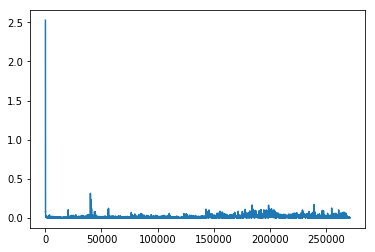

In [15]:
plt.plot(cost_graph)